# 03 — Collaborative Filtering (From Scratch)
### CSC 577 | Team Rocket | Food.com Recipe Recommender

This notebook implements two CF approaches **without any recommendation library**:

1. **User-Based CF** — find similar users via cosine similarity, predict ratings from neighbors
2. **SVD Matrix Factorization** — decompose the rating matrix into latent factors using `scipy`

Both models produce a ranked list of top-N candidate recipes per user, which is then passed to `04_constraint_filtering.ipynb`.

**Inputs:** `data/processed/interactions_clean.csv`  
**Outputs:** `data/processed/cf_ubased_candidates.csv`, `data/processed/cf_svd_candidates.csv`, `data/processed/test_with_predictions.csv`

## 0. Imports

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from scipy.sparse.linalg import svds
from sklearn.model_selection import train_test_split
import warnings
import os

warnings.filterwarnings('ignore')
os.makedirs('../data/processed', exist_ok=True)
os.makedirs('../results', exist_ok=True)

np.random.seed(42)
print('Libraries loaded.')

Libraries loaded.


## 1. Load Processed Data

In [18]:
interactions = pd.read_csv('../data/processed/interactions_clean.csv')

print(f'Interactions: {len(interactions):,} rows')
print(f'Users:        {interactions["user_id"].nunique():,}')
print(f'Recipes:      {interactions["recipe_id"].nunique():,}')
interactions.head(3)

Interactions: 469,637 rows
Users:        9,087
Recipes:      36,756


,user_id,recipe_id,rating,date,user_idx,recipe_idx
0,226867,363072,5,2018-12-18,3472,33295
1,1290903,131607,5,2018-12-18,8508,17700
2,2001513060,192495,5,2018-12-17,9082,23370


## 2. Train / Test Split

We hold out 20% of interactions **per user** so every user has ratings in both sets.

In [19]:
def train_test_split_per_user(df, test_size=0.2, random_state=42):
    """
    For each user, randomly hold out test_size fraction of their ratings.
    Users with fewer than 5 ratings go entirely into train.
    """
    train_list, test_list = [], []
    for _, group in df.groupby('user_id'):
        if len(group) < 5:
            train_list.append(group)
            continue
        train_g, test_g = train_test_split(
            group, test_size=test_size, random_state=random_state
        )
        train_list.append(train_g)
        test_list.append(test_g)

    return (
        pd.concat(train_list).reset_index(drop=True),
        pd.concat(test_list).reset_index(drop=True)
    )


train_df, test_df = train_test_split_per_user(interactions)
print(f'Train: {len(train_df):,} interactions')
print(f'Test:  {len(test_df):,} interactions')

Train: 372,115 interactions
Test:  97,522 interactions


## 3. Build the Rating Matrix

We build a dense user × recipe matrix from the **training set only**.

Then we **mean-center** each user's ratings — subtract their average rating from every rated item. This corrects for user bias (e.g., a strict rater who never gives 5★ vs. a generous one who almost always does), which makes cosine similarity and SVD work much better.

In [20]:
# Build contiguous index mappings from training data
all_users   = sorted(train_df['user_id'].unique())
all_recipes = sorted(train_df['recipe_id'].unique())

user2idx   = {u: i for i, u in enumerate(all_users)}
recipe2idx = {r: i for i, r in enumerate(all_recipes)}
idx2user   = {i: u for u, i in user2idx.items()}
idx2recipe = {i: r for r, i in recipe2idx.items()}

n_users   = len(all_users)
n_recipes = len(all_recipes)

print(f'Matrix size: {n_users:,} users × {n_recipes:,} recipes')

train_df['u_idx'] = train_df['user_id'].map(user2idx)
train_df['r_idx'] = train_df['recipe_id'].map(recipe2idx)

# Build sparse matrix then convert to dense
R_sparse = csr_matrix(
    (train_df['rating'].values,
     (train_df['u_idx'].values, train_df['r_idx'].values)),
    shape=(n_users, n_recipes)
)
R_dense = R_sparse.toarray().astype(np.float64)

print(f'Sparsity: {1 - R_sparse.nnz / (n_users * n_recipes):.4%}')

Matrix size: 9,087 users × 36,753 recipes
Sparsity: 99.8886%


In [21]:
# Mean-center each user's ratings (only over rated items)
rated_mask = R_dense > 0
R_nan      = np.where(rated_mask, R_dense, np.nan)
user_means = np.nanmean(R_nan, axis=1)   # shape: (n_users,)

R_centered = R_dense.copy()
R_centered[rated_mask] -= user_means[np.where(rated_mask)[0]]

print('Mean-centered matrix built.')
print(f'User mean rating range: [{user_means.min():.2f}, {user_means.max():.2f}]')

Mean-centered matrix built.
User mean rating range: [2.50, 5.00]


---
## Part A — User-Based Collaborative Filtering

**Steps:**
1. Compute pairwise cosine similarity between all user vectors
2. For a target user + candidate recipe, find the top-K neighbors who rated that recipe
3. Predict rating = user_mean + weighted average of neighbors' mean-centered ratings
4. Rank all unseen recipes by predicted rating

### A1. Cosine Similarity Between Users

In [22]:
def cosine_similarity_matrix(matrix):
    """Row-wise cosine similarity. Returns (n x n) matrix."""
    norms = np.linalg.norm(matrix, axis=1, keepdims=True)
    norms[norms == 0] = 1e-9
    normed = matrix / norms
    return normed @ normed.T

print('Computing user-user cosine similarity matrix...')
user_sim = cosine_similarity_matrix(R_centered)
np.fill_diagonal(user_sim, 0)   # A user is not their own neighbor

print(f'Similarity matrix: {user_sim.shape}')
print(f'Value range: [{user_sim.min():.4f}, {user_sim.max():.4f}]')

Computing user-user cosine similarity matrix...
Similarity matrix: (9087, 9087)
Value range: [-0.6882, 0.9714]


### A2. Vectorized UB-CF Prediction Matrix

Instead of predicting one (user, recipe) pair at a time (which is extremely slow), we compute the **entire predicted rating matrix in one matrix operation**:

```
numerator   = user_sim @ R_centered      # weighted sum of centered ratings
denominator = |user_sim| @ rated_mask   # sum of |similarities| per recipe
R_pred_ubcf = numerator / denominator + user_means
```

This is mathematically identical to the neighbor-weighted formula but runs in seconds instead of hours.

In [23]:
TOP_N = 20

print('Computing UB-CF predicted rating matrix (vectorized)...')

rated_mask = (R_dense > 0).astype(np.float64)   # 1 where rated, 0 elsewhere

# Only use positive similarities (negative similarity = dissimilar users, ignore them)
sim_positive = np.maximum(user_sim, 0)

# Numerator: weighted sum of mean-centered ratings across all users
numerator = sim_positive @ R_centered            # (n_users, n_recipes)

# Denominator: sum of similarities for neighbors who rated each recipe
denominator = sim_positive @ rated_mask          # (n_users, n_recipes)

# Avoid division by zero — where no neighbor rated a recipe, use 0
with np.errstate(invalid='ignore', divide='ignore'):
    R_pred_ubcf_centered = np.where(denominator > 0, numerator / denominator, 0.0)

# Un-center: add each user's mean rating back
R_pred_ubcf = R_pred_ubcf_centered + user_means.reshape(-1, 1)

# Clip to valid range
R_pred_ubcf = np.clip(R_pred_ubcf, 1.0, 5.0)

print(f'Predicted UB-CF matrix shape: {R_pred_ubcf.shape}')
print(f'Predicted rating range: [{R_pred_ubcf.min():.2f}, {R_pred_ubcf.max():.2f}]')
print('Done.')

Computing UB-CF predicted rating matrix (vectorized)...
Predicted UB-CF matrix shape: (9087, 36753)
Predicted rating range: [1.00, 5.00]
Done.


### A3. Generate Top-N Candidates for All Users

In [24]:
print(f'Extracting top-{TOP_N} UB-CF candidates for all {n_users:,} users...')

# Mask out already-rated items by setting their predicted score to -inf
R_pred_ubcf_masked = R_pred_ubcf.copy()
R_pred_ubcf_masked[R_dense > 0] = -np.inf

# For each user, argsort their row descending and take top-N
# np.argsort on the full matrix is fast
top_n_indices = np.argsort(-R_pred_ubcf_masked, axis=1)[:, :TOP_N]   # (n_users, TOP_N)
top_n_scores  = np.take_along_axis(R_pred_ubcf_masked, top_n_indices, axis=1)

# Build output dataframe
ubcf_rows = []
for u_idx in range(n_users):
    for rank in range(TOP_N):
        r_idx = top_n_indices[u_idx, rank]
        pred  = top_n_scores[u_idx, rank]
        if pred == -np.inf:
            continue   # no valid candidate at this rank
        ubcf_rows.append({
            'user_id':          idx2user[u_idx],
            'recipe_id':        idx2recipe[r_idx],
            'predicted_rating': round(float(pred), 4),
            'rank':             rank + 1
        })

ubcf_df = pd.DataFrame(ubcf_rows)
ubcf_df.to_csv('../data/processed/cf_ubased_candidates.csv', index=False)
print(f'Saved cf_ubased_candidates.csv — {len(ubcf_df):,} rows')
ubcf_df.head()

Extracting top-20 UB-CF candidates for all 9,087 users...
Saved cf_ubased_candidates.csv — 181,740 rows


,user_id,recipe_id,predicted_rating,rank
0,1533,511995,5.0,1
1,1533,126445,5.0,2
2,1533,126463,5.0,3
3,1533,126496,5.0,4
4,1533,148068,5.0,5


---
## Part B — SVD Matrix Factorization

**Steps:**
1. Decompose R_centered ≈ U · Σ · Vᵀ  using truncated SVD (keep top-k factors)
2. Reconstruct full predicted matrix: R_pred = U · Σ · Vᵀ + user_means
3. For each user, rank unseen recipes by predicted rating

### B1. Truncated SVD Decomposition

In [25]:
K_FACTORS = 50   # number of latent factors

print(f'Running truncated SVD (k={K_FACTORS})...')

# scipy svds returns singular values in ascending order — reverse them
U, sigma, Vt = svds(R_centered, k=K_FACTORS)
U, sigma, Vt = U[:, ::-1], sigma[::-1], Vt[::-1, :]

print(f'U:     {U.shape}   (users × factors)')
print(f'sigma: {sigma.shape}  (singular values)')
print(f'Vt:    {Vt.shape}  (factors × recipes)')

Running truncated SVD (k=50)...
U:     (9087, 50)   (users × factors)
sigma: (50,)  (singular values)
Vt:    (50, 36753)  (factors × recipes)


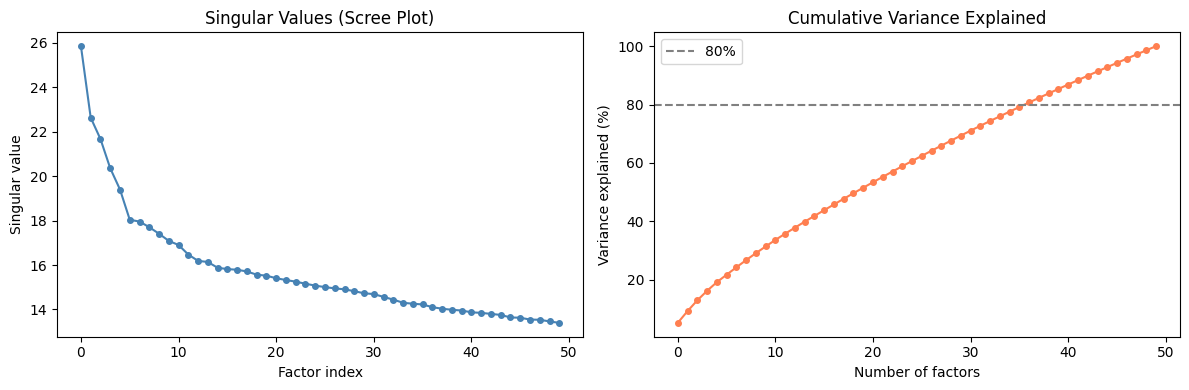

Variance explained by 50 factors: 100.00%


In [26]:
# Visualize variance explained by each latent factor
cumvar = np.cumsum(sigma**2) / (sigma**2).sum()

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(sigma, 'o-', color='steelblue', markersize=4)
axes[0].set_title('Singular Values (Scree Plot)')
axes[0].set_xlabel('Factor index')
axes[0].set_ylabel('Singular value')

axes[1].plot(cumvar * 100, 'o-', color='coral', markersize=4)
axes[1].axhline(80, color='gray', linestyle='--', label='80%')
axes[1].set_title('Cumulative Variance Explained')
axes[1].set_xlabel('Number of factors')
axes[1].set_ylabel('Variance explained (%)')
axes[1].legend()

plt.tight_layout()
plt.savefig('../results/svd_variance.png', bbox_inches='tight')
plt.show()
print(f'Variance explained by {K_FACTORS} factors: {cumvar[-1]*100:.2f}%')

### B2. Reconstruct Predicted Rating Matrix

In [27]:
# Reconstruct and un-center
R_pred = np.dot(U, np.dot(np.diag(sigma), Vt)) + user_means.reshape(-1, 1)
R_pred = np.clip(R_pred, 1.0, 5.0)

print(f'Predicted matrix shape: {R_pred.shape}')
print(f'Predicted rating range: [{R_pred.min():.2f}, {R_pred.max():.2f}]')

Predicted matrix shape: (9087, 36753)
Predicted rating range: [1.00, 5.00]


### B3. Generate Top-N Candidates for All Users

In [28]:
def get_top_n_svd(user_idx, R_actual, R_predicted, N=20):
    """Return top-N unrated recipes for a user based on SVD predicted ratings."""
    already_rated = set(np.where(R_actual[user_idx] > 0)[0])
    pred_row = R_predicted[user_idx].copy()
    for r in already_rated:
        pred_row[r] = -np.inf   # exclude already-rated items
    top_idx = np.argsort(pred_row)[::-1][:N]
    return [(r, float(pred_row[r])) for r in top_idx]


print(f'Generating top-{TOP_N} SVD candidates for all {n_users:,} users...')

svd_rows = []
for u_idx in range(n_users):
    for rank, (r_idx, pred) in enumerate(
        get_top_n_svd(u_idx, R_dense, R_pred, TOP_N), 1
    ):
        svd_rows.append({
            'user_id':          idx2user[u_idx],
            'recipe_id':        idx2recipe[r_idx],
            'predicted_rating': round(pred, 4),
            'rank':             rank
        })

svd_df = pd.DataFrame(svd_rows)
svd_df.to_csv('../data/processed/cf_svd_candidates.csv', index=False)
print(f'Saved cf_svd_candidates.csv — {len(svd_df):,} rows')
svd_df.head()

Generating top-20 SVD candidates for all 9,087 users...
Saved cf_svd_candidates.csv — 181,740 rows


,user_id,recipe_id,predicted_rating,rank
0,1533,54257,4.8556,1
1,1533,81853,4.8450,2
2,1533,75302,4.8429,3
3,1533,87782,4.8415,4
4,1533,63689,4.8406,5


## 4. Save Outputs for Evaluation

In [29]:
# Save train/test splits
train_df.to_csv('../data/processed/train.csv', index=False)
test_df.to_csv('../data/processed/test.csv',   index=False)
print(f'Saved train.csv ({len(train_df):,} rows) and test.csv ({len(test_df):,} rows)')

# Add model predictions to test set for RMSE/MAE in notebook 05
test_eval = test_df.copy()
test_eval['u_idx'] = test_eval['user_id'].map(user2idx)
test_eval['r_idx'] = test_eval['recipe_id'].map(recipe2idx)

# Drop cold-start rows (user or recipe not in training set)
test_eval = test_eval.dropna(subset=['u_idx', 'r_idx'])
test_eval[['u_idx', 'r_idx']] = test_eval[['u_idx', 'r_idx']].astype(int)

# SVD predictions — just index into R_pred
test_eval['svd_pred'] = [
    R_pred[row.u_idx, row.r_idx] for row in test_eval.itertuples()
]

# UB-CF predictions — index into the vectorized R_pred_ubcf matrix (fast!)
test_eval['ubcf_pred'] = [
    R_pred_ubcf[row.u_idx, row.r_idx] for row in test_eval.itertuples()
]

test_eval.to_csv('../data/processed/test_with_predictions.csv', index=False)
print(f'Saved test_with_predictions.csv — {len(test_eval):,} rows')
test_eval[['user_id', 'recipe_id', 'rating', 'svd_pred', 'ubcf_pred']].head()

Saved train.csv (372,115 rows) and test.csv (97,522 rows)
Saved test_with_predictions.csv — 97,507 rows


,user_id,recipe_id,rating,svd_pred,ubcf_pred
0,1533,14777,5,4.833358,5.000000
1,1533,46877,5,4.832403,5.000000
2,1533,44300,5,4.833353,4.995902
3,1533,23891,5,4.833135,4.933167
4,1533,8857,5,4.833334,4.833333


## 5. Quick Accuracy Preview

In [30]:
def rmse(actual, predicted):
    return np.sqrt(np.mean((actual - predicted) ** 2))

def mae(actual, predicted):
    return np.mean(np.abs(actual - predicted))

actual          = test_eval['rating'].values
svd_preds       = test_eval['svd_pred'].values
ubcf_preds      = test_eval['ubcf_pred'].values
baseline_preds  = test_eval['u_idx'].map(
    {i: user_means[i] for i in range(len(user_means))}
).values

print('=== Quick Accuracy Preview (full evaluation in notebook 05) ===')
print(f'{"Model":<18} {"RMSE":>8} {"MAE":>8}')
print('-' * 36)
print(f'{"SVD":<18} {rmse(actual, svd_preds):>8.4f} {mae(actual, svd_preds):>8.4f}')
print(f'{"User-Based CF":<18} {rmse(actual, ubcf_preds):>8.4f} {mae(actual, ubcf_preds):>8.4f}')
print(f'{"Baseline (mean)":<18} {rmse(actual, baseline_preds):>8.4f} {mae(actual, baseline_preds):>8.4f}')

=== Quick Accuracy Preview (full evaluation in notebook 05) ===
Model                  RMSE      MAE
------------------------------------
SVD                  0.5609   0.3544
User-Based CF        0.6182   0.3660
Baseline (mean)      0.5610   0.3546


## Summary

| Model | Key idea | Implementation |
|---|---|---|
| **User-Based CF** | Similar users rate recipes similarly | Cosine similarity on mean-centered ratings, top-K weighted average |
| **SVD** | Latent factors capture taste patterns | `scipy.sparse.linalg.svds`, reconstruct full rating matrix |

**Files saved:**
- `data/processed/train.csv` — training interactions
- `data/processed/test.csv` — held-out test interactions  
- `data/processed/cf_ubased_candidates.csv` — top-20 UB-CF candidates per user
- `data/processed/cf_svd_candidates.csv` — top-20 SVD candidates per user
- `data/processed/test_with_predictions.csv` — test set with both models' predictions